In [7]:
!pip install torchvision
!pip install torchinfo
!pip install torchmetrics
!pip install
!pip install wandb -qU

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: You must give at least one requirement to install (see "pip help install")

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchmetrics
from torchinfo import summary
import torchvision.models as models
%matplotlib inline

In [9]:
labels_training = pd.read_csv("Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv")
labels_testing = pd.read_csv("Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv")
labels_training.dropna(axis = 1, inplace = True)
labels_training, labels_testing

(    Image name  Retinopathy grade  Risk of macular edema 
 0    IDRiD_001                  3                       2
 1    IDRiD_002                  3                       2
 2    IDRiD_003                  2                       2
 3    IDRiD_004                  3                       2
 4    IDRiD_005                  4                       0
 ..         ...                ...                     ...
 408  IDRiD_409                  2                       1
 409  IDRiD_410                  2                       0
 410  IDRiD_411                  2                       0
 411  IDRiD_412                  2                       0
 412  IDRiD_413                  2                       0
 
 [413 rows x 3 columns],
     Image name  Retinopathy grade  Risk of macular edema 
 0    IDRiD_001                  4                       0
 1    IDRiD_002                  4                       1
 2    IDRiD_003                  4                       0
 3    IDRiD_004              

## Trying to Address Class Imbalance

In [7]:
## Class Imbalance 


# Resize - 224,224
# batch = 32
# learning = 0.0001



import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms for training and augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# No augmentation for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Class weights for the dataset
class_weights = [0.324455, 0.048426, 0.329298, 0.179177, 0.118644]

# Load the dataset
training_path = "Disease Grading/1. Original Images/a. Training Directory"
testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

train_dataset = torchvision.datasets.ImageFolder(training_path, transform=transform_train)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform=transform_val_test)

# Create a WeightedRandomSampler to address class imbalance
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(train_dataset), replacement=True)

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(output_size) 
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CNN(kernel_size=3, output_size=5)

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f},Accuracy :{epoch_accuracy:.4f}')

# Evaluate the model on validation set
model.eval()
correct_val = 0
total_val = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
val_accuracy = 100 * correct_val / total_val
print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

# Evaluate the model on test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = 100 * correct_test / total_test
print('Test Accuracy: {:.2f}%'.format(test_accuracy))


Epoch [1/10], Loss: 1.0084,Accuracy :51.9637
Epoch [2/10], Loss: 0.8724,Accuracy :52.5680
Epoch [3/10], Loss: 0.8122,Accuracy :61.3293
Epoch [4/10], Loss: 0.8064,Accuracy :61.9335
Epoch [5/10], Loss: 0.8525,Accuracy :58.0060
Epoch [6/10], Loss: 0.7255,Accuracy :66.7674
Epoch [7/10], Loss: 0.7701,Accuracy :64.6526
Epoch [8/10], Loss: 0.7319,Accuracy :60.7251
Epoch [9/10], Loss: 0.7544,Accuracy :55.5891
Epoch [10/10], Loss: 0.6665,Accuracy :67.6737
Validation Accuracy: 32.93%
Test Accuracy: 33.01%


Create sweep with ID: n8nvmbmh
Sweep URL: https://wandb.ai/pmpbu/grp4-class_imb/sweeps/n8nvmbmh


wandb: Agent Starting Run: qcv6t8q1 with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Loss: 94.2370, Accuracy: 33.53%
Epoch [2/10], Loss: 146.7608, Accuracy: 45.32%
Epoch [3/10], Loss: 71.3767, Accuracy: 48.04%
Epoch [4/10], Loss: 48.7296, Accuracy: 48.04%
Epoch [5/10], Loss: 73.7120, Accuracy: 64.05%
Epoch [6/10], Loss: 27.1692, Accuracy: 35.65%
Epoch [7/10], Loss: 26.5444, Accuracy: 65.86%
Epoch [8/10], Loss: 17.7532, Accuracy: 38.67%
Epoch [9/10], Loss: 7.8696, Accuracy: 46.22%
Epoch [10/10], Loss: 17.5069, Accuracy: 40.48%
Validation Accuracy: 34.15%
Test Accuracy: 33.01%


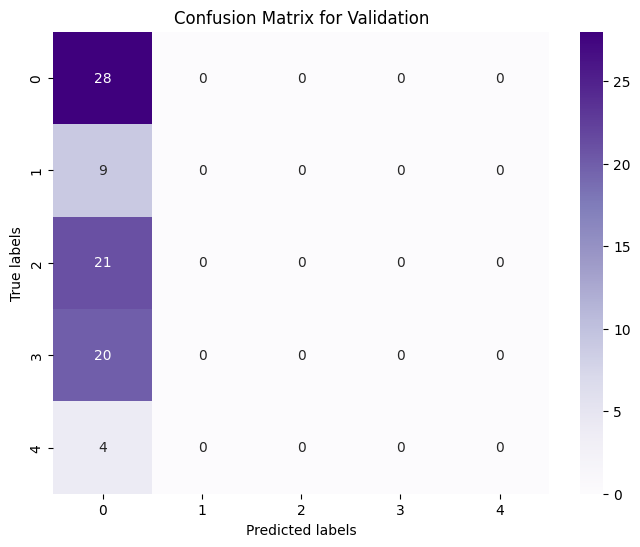

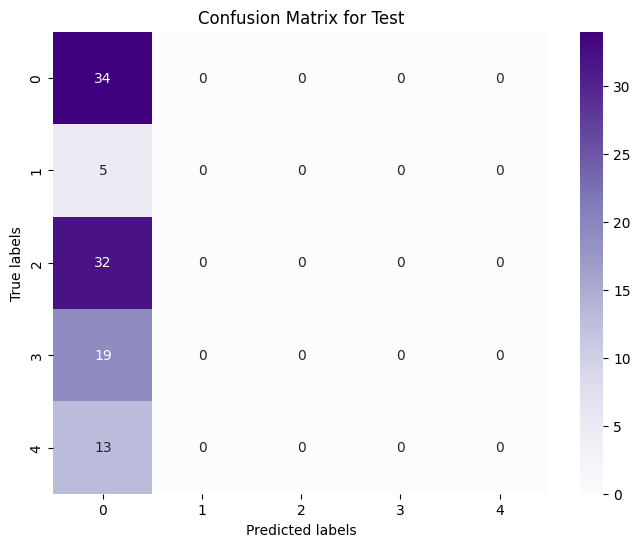

test_accuracy,33.00971
val_accuracy,34.14634


wandb: Agent Starting Run: vdboocj4 with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 6.8232, Accuracy: 48.94%
Epoch [2/10], Loss: 2.1432, Accuracy: 54.08%
Epoch [3/10], Loss: 1.4481, Accuracy: 46.83%
Epoch [4/10], Loss: 1.2911, Accuracy: 64.05%
Epoch [5/10], Loss: 1.0645, Accuracy: 67.07%
Epoch [6/10], Loss: 0.9774, Accuracy: 69.49%
Epoch [7/10], Loss: 0.9875, Accuracy: 68.28%
Epoch [8/10], Loss: 0.9662, Accuracy: 68.58%
Epoch [9/10], Loss: 1.0102, Accuracy: 62.54%
Epoch [10/10], Loss: 0.8960, Accuracy: 64.65%
Validation Accuracy: 24.39%
Test Accuracy: 13.59%


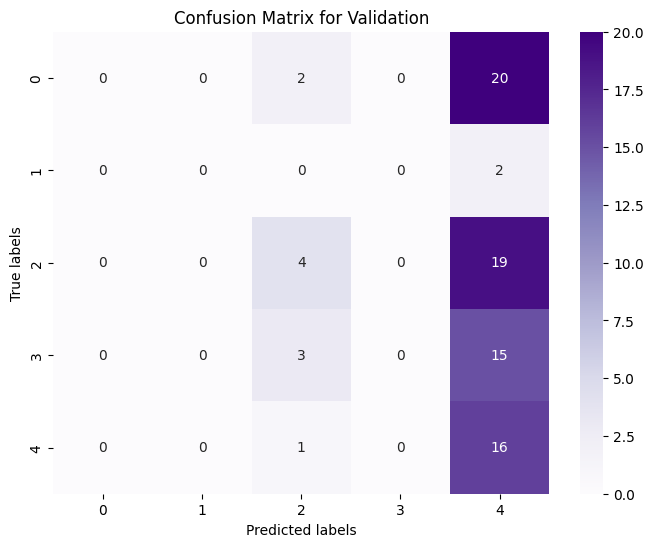

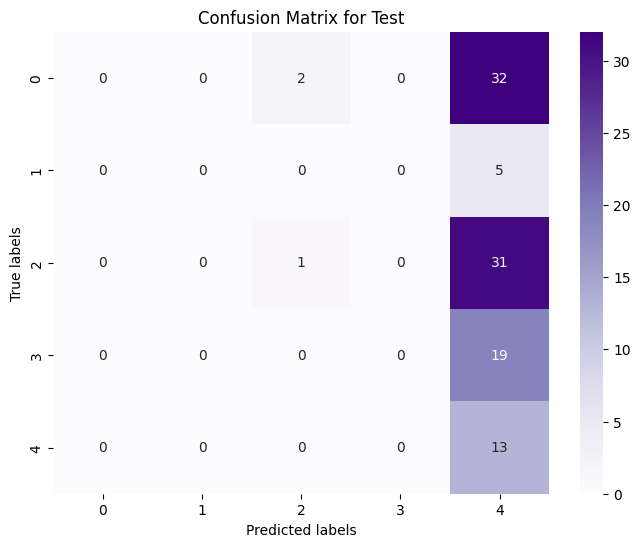

test_accuracy,13.59223
val_accuracy,24.39024


wandb: Agent Starting Run: 139h9fxl with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 1.3314, Accuracy: 71.00%
Epoch [2/10], Loss: 1.0634, Accuracy: 57.70%
Epoch [3/10], Loss: 0.8648, Accuracy: 71.90%
Epoch [4/10], Loss: 0.7624, Accuracy: 70.39%
Epoch [5/10], Loss: 0.7860, Accuracy: 69.18%
Epoch [6/10], Loss: 0.7093, Accuracy: 78.25%
Epoch [7/10], Loss: 0.6977, Accuracy: 71.90%
Epoch [8/10], Loss: 0.6617, Accuracy: 78.25%
Epoch [9/10], Loss: 0.4995, Accuracy: 75.23%
Epoch [10/10], Loss: 0.5269, Accuracy: 77.34%
Validation Accuracy: 35.37%
Test Accuracy: 40.78%


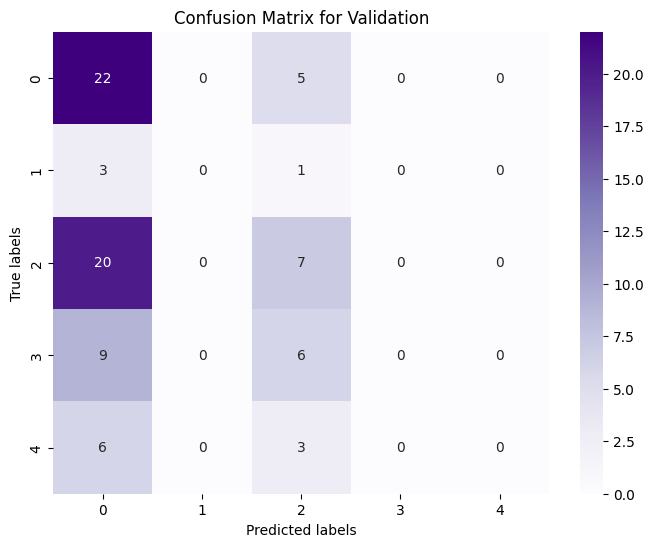

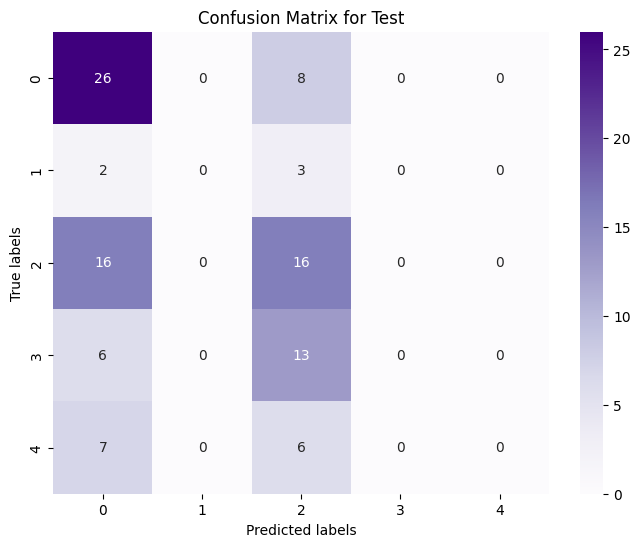

test_accuracy,40.7767
val_accuracy,35.36585


wandb: Agent Starting Run: 523un9h0 with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 67.1177, Accuracy: 28.40%
Epoch [2/10], Loss: 49.8657, Accuracy: 33.84%
Epoch [3/10], Loss: 42.1086, Accuracy: 33.53%
Epoch [4/10], Loss: 38.9268, Accuracy: 35.05%
Epoch [5/10], Loss: 26.2196, Accuracy: 30.21%
Epoch [6/10], Loss: 15.6280, Accuracy: 33.84%
Epoch [7/10], Loss: 7.0122, Accuracy: 36.86%
Epoch [8/10], Loss: 6.4655, Accuracy: 33.23%
Epoch [9/10], Loss: 4.2356, Accuracy: 35.95%


In [ ]:
# Class Imbalance Sweep

# Resize - 448,500
# "batch_size": {"values": [64, 32, 15]},
# "learning_rate": {"values": [1e-2, 1e-3, 1e-4]},
# 'kernel_size': {'values': [2, 3]}


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler


# Initialize WandB
wandb.login()

# Define sweep configuration
sweep_configuration = {
    "method": "grid",
    "name": "class_imbalance",
    "metric": {"goal": "maximize", "name": "val_acc"},
    "parameters": {
        "batch_size": {"values": [64, 32, 15]},
        "learning_rate": {"values": [1e-2, 1e-3, 1e-4]},
        'kernel_size': {'values': [2,3]}
    }
}

# Main function to run a single experiment
def main():
    run = wandb.init()

    # Load data
    training_path = "Disease Grading/1. Original Images/a. Training Directory"
    testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

    # Define transforms for training and augmentation
    transform_train = transforms.Compose([
        transforms.Resize((448, 500)),  # Resize images to a fixed size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
    ])

    # No augmentation for validation and test sets
    transform_val_test = transforms.Compose([
        transforms.Resize((448, 500)),
        transforms.ToTensor(),
    ])

    # Class weights for the dataset
    class_weights = [0.324455, 0.048426, 0.329298, 0.179177, 0.118644]

    train_dataset = torchvision.datasets.ImageFolder(training_path, transform=transform_train)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
    test_dataset = torchvision.datasets.ImageFolder(testing_path, transform=transform_val_test)

    # Data loaders
    sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(train_dataset), replacement=True)

    # DataLoader for training and validation
    train_loader = DataLoader(train_dataset, batch_size=run.config.batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=run.config.batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.config.batch_size, shuffle=False)

    # Define the CNN model
    class CNN(nn.Module):
        def __init__(self, kernel_size, output_size):
            super(CNN, self).__init__()
            self.model = nn.Sequential(
                nn.Conv2d(3, 4, kernel_size),
                nn.ReLU(),
                nn.Conv2d(4, 8, kernel_size),
                nn.ReLU(),
                nn.Conv2d(8, 16, kernel_size),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size),
                nn.MaxPool2d(2),
                nn.Flatten(),
                nn.LazyLinear(output_size) 
            )

        def forward(self, x):
            return self.model(x)

    # Initialize the model
    model = CNN(kernel_size=3, output_size=5)

    # Training the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=run.config.learning_rate)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_preds.extend(predicted.tolist())
            val_targets.extend(labels.tolist())
    val_accuracy = 100 * correct_val / total_val
    print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

    # Log validation accuracy
    wandb.run.summary["val_accuracy"] = val_accuracy

    # Evaluate the model on test set
    correct_test = 0
    total_test = 0
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_preds.extend(predicted.tolist())
            test_targets.extend(labels.tolist())
    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: {:.2f}%'.format(test_accuracy))

    # Log test accuracy
    wandb.run.summary["test_accuracy"] = test_accuracy

    # Confusion matrix for validation set
    val_conf_matrix = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Purples")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix for Validation")
    plt.show()

    # Confusion matrix for test set
    test_conf_matrix = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Purples")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix for Test")
    plt.show()


# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project='grp4-class_imb')

# Start sweep job
wandb.agent(sweep_id, function=main)


Published WandB Report:

https://wandb.ai/pmpbu/grp4_sampler/reports/Addressing-Class-Imbalance---Vmlldzo3NzAzNTM1

## Image Transformations with Color

In [4]:
configs = {
    "experiment_name": "Baseline",
    "freeze_feature_extraction_layers": True,
    "pretrained":False,
    "efficientnet":False, # off-> Resnet18
    "data_augmentation":True,
    "transferlearning": False,

    # Data
    "img_dimensions" : (3, 356, 536),
    "batch_size" : 32,
    "num_classes" : 5,

    # CNN
    "filter_sizes" : [4,8,16],
    "kernel_size" : 5,
    "stride": 1,
    "padding":0,

    #Optimzation
    "learning_rate" : 0.001,
    "epochs" : 10,
    "weight_decay" : 0.00001,
    "patience" : 5
}

In [163]:
# Trying different Transformations



training_path = "Disease Grading/1. Original Images/a. Training Directory"
testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

if configs["data_augmentation"]:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize([224,300]),
#         transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#         transforms.Pad((0, 25, 0, 25)),
        transforms.RandomRotation(20),
#         transforms.RandomZoomOut(0.2),
#         transforms.RandomSolarize(0.8),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(training_path, transform = transform)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform = transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset,  shuffle=False)
test_loader = DataLoader(dataset=test_dataset,  shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


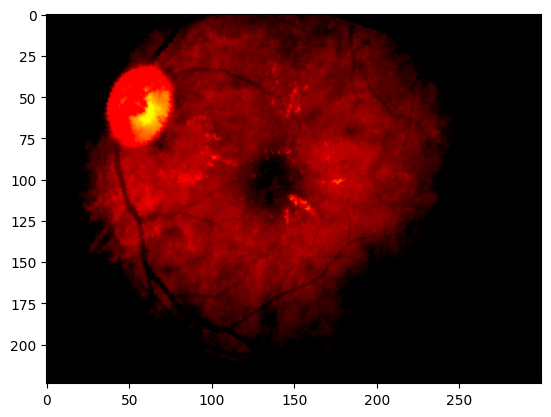

In [164]:
for input,label in train_loader:
    x = input
    y = label
    break
    
plt.imshow(x[0].permute(1,2,0))

In [165]:
y

tensor([2])

In [166]:
# Trying heatmap for transformation (red channel)



from PIL import Image
# Create heatmap image in red channel
heatmap = torch.empty(1, 224,300).uniform_(0, 1)
heatmap = torch.cat((heatmap, torch.zeros(2, 224,300)))

import torchvision.transforms.functional as TF
img = TF.to_pil_image(x[0])  # assuming your image in x
h_img = TF.to_pil_image(heatmap)

res = Image.blend(img, h_img, 0.5)

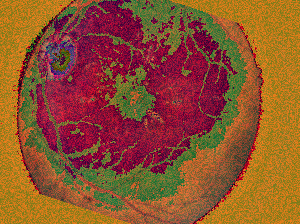

In [167]:
res

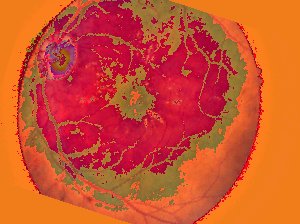

In [168]:
# Trying heatmap for transformation (all 3 channels)


import torch
from PIL import Image
import torchvision.transforms.functional as TF

# Create heatmap image with different color channels
# Assuming you want to create a heatmap with red color channel
red_channel = torch.empty(1, 224, 300).fill_(1)  # Fill the red channel with 1
green_channel = torch.zeros(1, 224, 300)  # Create empty tensor for green channel
blue_channel = torch.zeros(1, 224, 300)  # Create empty tensor for blue channel

# Concatenate the color channels to create the heatmap
heatmap = torch.cat((red_channel, green_channel, blue_channel), dim=0)

# Convert the heatmap tensor to PIL image
h_img = TF.to_pil_image(heatmap)

# Assuming you have an image tensor x
# Convert the image tensor to PIL image
img = TF.to_pil_image(x[0])

# Blend the images
res = Image.blend(img, h_img, 0.5)
res

In [38]:
train_dataset[0][0].shape

torch.Size([3, 224, 300])

In [ ]:
## Trying CNNs for different color transformations 
# Took too long to run and could not see any improved results in the first 2-3 sweeps.



import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Initialize WandB
wandb.login()

# Define sweep configuration
sweep_configuration = {
    "method": "grid",
    "name": "rotate20",
    "metric": {"goal": "maximize", "name": "val_acc"},
    "parameters": {
        "batch_size": {"values": [32,15]},
        "learning_rate": {"values": [1e-2, 1e-3, 1e-4]},
        'kernel_size': {'values': [3,4]}
    }
}


# Define the CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size),
            torch.nn.ReLU(),
#             torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, kernel_size),
            torch.nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(output_size) 
        )

    def forward(self, x):
        return self.model(x)


# Main function to run a single experiment
def main():
    run = wandb.init()

    # Load data
    training_path = "Disease Grading/1. Original Images/a. Training Directory"
    testing_path = "Disease Grading/1. Original Images/b. Testing Directory"


    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize([224,300]),
#         transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#         transforms.Pad((0, 25, 0, 25)),
        transforms.RandomRotation(20),
#         transforms.RandomZoomOut(0.2),
#         transforms.RandomSolarize(0.8),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
            transforms.Resize(([224,300])),
            transforms.ToTensor()
            ])

    train_dataset = torchvision.datasets.ImageFolder(training_path, transform = transform)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
    test_dataset = torchvision.datasets.ImageFolder(testing_path, transform = test_transform)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.config.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.config.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.config.batch_size, shuffle=False)


    # Initialize model
    model = CNN(run.config.kernel_size, 5)

    # Training the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=run.config.learning_rate)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Evaluate the model on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

    # Log validation accuracy
    wandb.run.summary["val_accuracy"] = val_accuracy

    # Evaluate the model on test set
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: {:.2f}%'.format(test_accuracy))

    # Log test accuracy
    wandb.run.summary["test_accuracy"] = test_accuracy


# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project='work')

# Start sweep job
wandb.agent(sweep_id, function=main)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: pxanbzqs
Sweep URL: https://wandb.ai/pmpbu/work/sweeps/pxanbzqs
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: 3jmzorc4 with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01


wandb: WARNING Unable to render progress bar, see the user log for details
wandb: ERROR Problem finishing run
Exception in thread Thread-11 (_run_job):
Traceback (most recent call last):
  File "/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/scratch/6839680.1.iris-gpu-pub/ipykernel_964171/1208607019.py", line 100, in main
  File "/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/wandb/sdk/lib/redirect.py", line 640, in write
    self._old_write(data)
  File "/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/wandb/sdk/lib/redirect.py", line 640, in write
    self._old_write(data)
  File "/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/ipykernel/iostream.py", line 648, in write
    self._schedule_flush()
  File "/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/ipykernel/iostream.py", line 545, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_th

Epoch [3/10], Loss: 1.5190Epoch [1/10], Loss: 365.7935
Epoch [2/10], Loss: 102.4347
Epoch [3/10], Loss: 39.8530
Epoch [4/10], Loss: 22.8721
Epoch [5/10], Loss: 19.3905
Epoch [6/10], Loss: 15.1675
Epoch [7/10], Loss: 42.5660
Epoch [8/10], Loss: 52.6319
Epoch [9/10], Loss: 37.0510
Epoch [10/10], Loss: 18.2199
Validation Accuracy: 32.93%
Test Accuracy: 33.01%


Epoch [1/10], Loss: 5.7066
Epoch [2/10], Loss: 3.1301
Epoch [3/10], Loss: 1.9253
Epoch [4/10], Loss: 1.4365
Epoch [5/10], Loss: 1.4105
Epoch [6/10], Loss: 1.3051
Epoch [7/10], Loss: 1.3726
Epoch [8/10], Loss: 1.3178
Epoch [9/10], Loss: 1.2765
Epoch [10/10], Loss: 1.3061
Validation Accuracy: 25.61%
Test Accuracy: 33.01%


test_accuracy,33.00971
val_accuracy,25.60976


wandb: Agent Starting Run: htnzj1wt with config:
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


Epoch [1/10], Loss: 1.6525
Epoch [2/10], Loss: 1.4324
Epoch [3/10], Loss: 1.3621
